In [1]:
using Plots, PlotThemes, LaTeXStrings
using OffsetArrays
using LinearAlgebra
using FFTW
using StatsBase
using Unitful
using Base: Fix1, Fix2
using Distributions
using LaTeXStrings


theme(:mute)
default(;palette=:seaborn_deep6, fontfamily="serif")
j=im

im

In [2]:
S = OffsetArray(sqrt(13/6).*[0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 0,
0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0,0], -26:26)

shift(x) = [i in 1:26 ? x[i] : (i in 38:63 ? x[i-64] : 0.0+im*0.0) for i in 0:63]

function shift(x, ifft_points)
    x_shift = vcat(x[0:26], zeros(ifft_points-53), x[-26:-1])
    return x_shift
end

function make_preamble(sym) 
    sym2 = sym[length(sym)-Int(length(sym)/2)+1:end]
    return vcat(sym2, sym, sym)
end

function freq_to_wave(x, ifft_points)
    return shift(x, ifft_points) |> ifft |> make_preamble
end

freq_to_wave (generic function with 1 method)

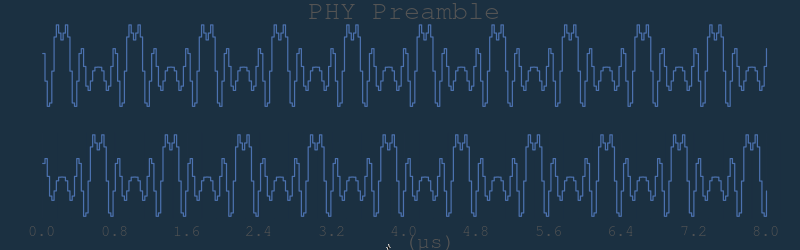

In [7]:
N = 128
sym = freq_to_wave(S, N)
t = range(0u"μs", 8u"μs", length=length(sym))
tiks = [0:0.8:8...]
p2 = plot(t, imag(sym), yticks=false, line=:steppost, ylabel="canal I", xlabel=L"t", xticks = tiks, title="")
p1 = plot(t, real(sym), yticks=false, line=:steppost, ylabel="canal Q", xlabel="", xticks=[], title="PHY Preamble")

plot(p1, p2, layout=(2,1), legend = false, size=(800,250), background_color="#1b3041")

In [6]:
norm(sym)

1.4252192813739224

In [4]:
function threshold(PFA, σ2, ref)
    return sqrt(-2*norm(ref)^2*σ2*log(PFA))
end

function PFA_t(T, σ2, ref) 
    return exp(-T^2/(2*norm(ref)^2*σ2))
end

PFA_t (generic function with 1 method)

In [5]:
threshold(10e-2, 0.1^2, sym)

0.21626664028795925

In [6]:
length(sym)

320

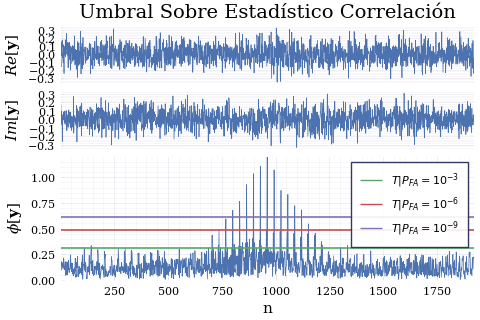

In [19]:
f_err = 0.000
N = length(sym)

σ = 0.1
d = Normal(0, σ)
sym_ferr = sym.*exp.(im*2*pi*f_err .* (1:N)) .+ rand(d, N) .+ j.*rand(d, N)

N = 5000
start_t = 3*length(sym)

y = vcat(zeros(start_t), sym, zeros(N-start_t-length(sym))) .+ rand(d, N) .+ j.*rand(d, N)
t = range(0u"μs", 16u"μs"/length(sym)*length(y), length=length(y))

function short_correlate(y, idx, ref)
    x1 = y[idx:idx+length(ref)-1]
    return x1'*ref
end
idxs = 1:start_t+3*length(sym)
est1 = vcat([short_correlate(y, i, sym) for i in idxs], zeros(length(sym)))

lims1 = (0, maximum(abs.(est1))).*1.2

p11 = plot(real(y[idxs]), xticks=false, xlims=extrema(idxs), ylabel=L"Re[\mathbf{y}]", xlabel="", linewidth=0.5, title="Umbral Sobre Estadístico Correlación")
p21 = plot(imag(y[idxs]), xticks=false, xlims=extrema(idxs), ylabel=L"Im[\mathbf{y}]", xlabel="", linewidth=0.5)
p1 = plot(p11,p21, layout=(2,1), legend=:false)
p2 = plot(abs.(est1[idxs]), xlims=extrema(idxs), ylabel=L"\phi[\mathbf{y}]", xlabel="n", label="", ylims=(0,1.2), linewidth=0.5)
PFA = 10e-3
T = threshold(PFA, σ^2, sym)
plot!(p2, [1, maximum(idxs)], [T, T], label=L"T|P_{FA}=10^{-3}")
PFA = 10e-6
T = threshold(PFA, σ^2, sym)
plot!(p2, [1, maximum(idxs)], [T, T], label=L"T|P_{FA}=10^{-6}")
PFA = 10e-9
T = threshold(PFA, σ^2, sym)
plot!(p2, [1, maximum(idxs)], [T, T], label=L"T|P_{FA}=10^{-9}")


plot(p1, p2, layout=(2,1), size=(600,400).*0.8)

In [20]:
savefig("Avance 2/Images/umbral_1.svg")

"/home/inox/Documents/IB/Proyecto Integrador/Avance 2/Images/umbral_1.svg"

In [9]:
function snr_calc(A, σ, ref)
    return (A*norm(ref))^2/(2*length(ref)*σ^2)
end
10*log10(snr_calc(1,σ,sym))

-7.994465913249189

In [10]:
function realization(y, ref, T)
    ϕ = abs(ref'*y)
    return ϕ >= T
end

function test_PFA(σ, ref, PFA)
    n_realz = 200/PFA |> ceil |> Int
    NFA = 0
    println(n_realz)
    T = threshold(PFA, σ^2, sym)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        y = rand(d, N) .+ j.*rand(d, N)
        if realization(y, ref, T)
            NFA += 1
        end
    end
    return NFA/n_realz
end        


test_PFA (generic function with 1 method)

2000000


1588657


1261915


1002375


796215


632456


502378


399053


316979


251786


200000


158866


126192


100238


79622


63246


50238


39906


31698


25179


20000


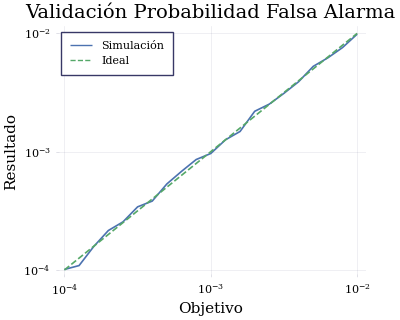

In [11]:
PFAs = 10.0 .^(-4:0.1:-2)
p1 = plot(PFAs, xlabel="Objetivo", ylabel="Resultado", title="Validación Probabilidad Falsa Alarma", [test_PFA(σ, sym, PFA) for PFA in PFAs], xaxis=:log, yaxis=:log, label="Simulación", legend=:topleft, size=(500,400).*0.8)
plot!(p1, PFAs, PFAs, linestyle=:dash, label="Ideal")

In [12]:
savefig("Avance 2/Images/pfa_test.svg")

"/home/inox/Documents/IB/Proyecto Integrador/Avance 2/Images/pfa_test.svg"

2000000


1588657


1261915


1002375


796215


632456


502378


399053


316979


251786


200000


158866


126192


100238


79622


63246


50238


39906


31698


25179


20000


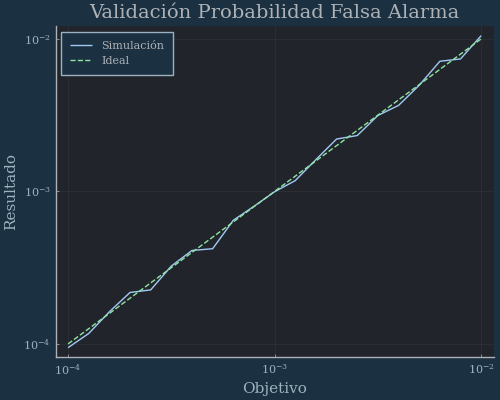

In [13]:
function test_PFA_est(σ, ref, PFA)
    n_realz = 200/PFA |> ceil |> Int
    NFA = 0
    println(n_realz)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        y = rand(d, N) .+ j.*rand(d, N)
        σ2_MMSE = norm(y)^2/(2*(length(y)-1))
        T = threshold(PFA, σ2_MMSE, sym)
        if realization(y, ref, T)
            NFA += 1
        end
    end
    return NFA/n_realz
end    

PFAs = 10.0 .^(-4:0.1:-2)
p1 = plot(PFAs, xlabel="Objetivo", ylabel="Resultado", title="Validación Probabilidad Falsa Alarma", [test_PFA(σ, sym, PFA) for PFA in PFAs], xaxis=:log, yaxis=:log, label="Simulación", legend=:topleft, size=(500,400))
plot!(p1, PFAs, PFAs, linestyle=:dash, label="Ideal")

In [2]:
function test_PD(σ, ref, PFA, A)
    n_realz = 100/(1-PFA) |> ceil |> Int
    ND = 0
    T = threshold(PFA, σ^2, sym)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        y = ref .+ rand(d, N) .+ j.*rand(d, N)
        if realization(y, ref, T)
            ND += 1
        end
    end
    return ND/n_realz
end        

test_PD (generic function with 1 method)

In [3]:
using ArbNumerics
using Trapz
using Plots


function int_arg(x, ref, A, σ)
     x_a = ArbReal(x)
     return x_a*exp(-(x_a^2+A^2*norm(ref)^2/σ^2)/2)*besseli(0,A*norm(ref)/σ*x_a)
end

## Nota: Acompañar A de ||s|| 

A = 1

guess = 5

xs1 = range(norm(sym)*1000-guess, norm(sym)*1000+guess, length=10000) 
xs2 = range(norm(sym)*100-guess,  norm(sym)*100+guess, length=10000)   
xs3 = range(norm(sym)*10-guess,   norm(sym)*10+guess, length=10000)  


p1 = plot(xs1, [int_arg(x1, sym, A,0.001) for x1 in xs1] )
p2 = plot(xs2, [int_arg(x2, sym, A,0.01)  for x2 in xs2] )
p3 = plot(xs3, [int_arg(x3, sym, A,0.1)   for x3 in xs3]  )

plot(p1,p2,p3,layout=(3,1))

UndefVarError: UndefVarError: `sym` not defined

In [4]:
function F_r(r, ref, σ, A)
    lb = r/(norm(ref)*σ)
    xmax = norm(ref)*A/σ
    guard = 7
    if lb < xmax - guard
        return 0
    elseif lb > xmax + guard
        return 1
    else
        xs = range(lb, xmax+guard, length=1000)
        return 1 - trapz(xs, [int_arg(x, ref, A, σ) for x in xs])
    end
end

xs1 = range(0, 5, length=1000)

p1 = plot(xs1, [F_r(x,sym,A,0.001) for x in xs1])

UndefVarError: UndefVarError: `sym` not defined

In [5]:
function PDofPFA_t(PFA, ref, σ, A)
    T = threshold(PFA, σ^2, ref)
    return 1-F_r(T,ref,σ,A)
end

function test_PD(σ, ref, PFA, A)
    n_realz = 100/PDofPFA_t(PFA,ref,σ,A) |> ceil |> Int
    ND = 0
    T = threshold(PFA, σ^2, sym)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        y = A.*ref .+ rand(d, N) .+ j.*rand(d, N)
        if realization(y, ref, T)
            ND += 1
        end
    end
    return ND/n_realz
end

PFAs = 10.0 .^(-4:0.5:-1)

σs = 10.0 .^(-3:0.1:1);

In [6]:
σs = 10.0 .^(-2:0.1:1)

PFA=0.1
p1 = plot(σs, [PDofPFA_t(PFA, sym, σ, A) for σ in σs], ylabel="PD", label="T",title="PFA=10^-2", xaxis=:log)
plot!(p1, σs, [test_PD(σ, sym, PFA, A) for σ in σs], xaxis=:log, label="E")
PFA=0.01
p2 = plot(σs, [PDofPFA_t(PFA, sym, σ, A) for σ in σs], ylabel="PD", label="T",title="PFA=10^-3", xaxis=:log)
plot!(p2, σs, [test_PD(σ, sym, PFA, A) for σ in σs], xaxis=:log, label="E")
PFA=0.001
p3 = plot(σs, [PDofPFA_t(PFA, sym, σ, A) for σ in σs], ylabel="PD", label="T",title="PFA=10^-4", xaxis=:log, xlabel="σ")
plot!(p3, σs, [test_PD(σ, sym, PFA, A) for σ in σs], xaxis=:log, label="E")

plot(p1,p2,p3, layout=(3,1))

UndefVarError: UndefVarError: `sym` not defined

In [7]:
σ = 0.1
As = 10.0 .^(-2:0.1:1)

PFA=0.1
p1 = plot(As, [PDofPFA_t(PFA, sym, σ, A) for A in As], ylabel="PD", label="T",title="PFA=10^-2", xaxis=:log)
plot!(p1, As, [test_PD(σ, sym, PFA, A) for A in As], xaxis=:log, label="E")
PFA=0.01
p2 = plot(As, [PDofPFA_t(PFA, sym, σ, A) for A in As], ylabel="PD", label="T",title="PFA=10^-3", xaxis=:log)
plot!(p2, As, [test_PD(σ, sym, PFA, A) for A in As], xaxis=:log, label="E")
PFA=0.001
p3 = plot(As, [PDofPFA_t(PFA, sym, σ, A) for A in As], ylabel="PD", label="T",title="PFA=10^-4", xaxis=:log, xlabel="A")
plot!(p3, As, [test_PD(σ, sym, PFA, A) for A in As], xaxis=:log, label="E")

plot(p1,p2,p3, layout=(3,1))

UndefVarError: UndefVarError: `sym` not defined

In [9]:
PFAs = 2.0 .^(-12:1:-1)
A = 1

plt = palette(:seaborn_pastel6)

σ=2
p1 = plot(PFAs, [test_PD(σ, sym, PFA, A) for PFA in PFAs], color=plt[1], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2, xlabel="PFA", legend=:bottomright)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[1], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)
σ=1
plot!(p1, PFAs, [test_PD(σ, sym, PFA, A) for PFA in PFAs], color=plt[2], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[2], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)
σ=0.5
plot!(p1, PFAs, [test_PD(σ, sym, PFA, A) for PFA in PFAs], color=plt[3], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[3], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)
σ=0.25
plot!(p1, PFAs, [test_PD(σ, sym, PFA, A) for PFA in PFAs], color=plt[4], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[4], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)

UndefVarError: UndefVarError: `sym` not defined

In [10]:
function estimate_noise(μ, σ, N)
    d = Normal(0,σ)
    y = repeat([μ], N) .+ rand(d, N) .+ j.*rand(d, N)
    y_m = sum(y)/N
    return (norm(y.-y_m))^2/(2*(N-1))
end

N = length(sym)

σs = 10.0 .^(-5:0.1:1)

p1 = plot(σs.^2, estimate_noise.(10, σs,N), xaxis=:log, yaxis=:log, legend=false, xlabel="σ²", ylabel="σ^2 MMSE", title="Estimador MMSE")
plot!(p1, σs.^2, σs.^2, linestyle=:dash)

UndefVarError: UndefVarError: `sym` not defined

In [11]:
N = 5000
start_t = 2700

σ=0.01
d = Normal(0,σ)

y = vcat(zeros(start_t), sym, zeros(N-start_t-length(sym))) .+ rand(d, N) .+ j.*rand(d, N)
t = range(0u"μs", 16u"μs"/length(sym)*length(y), length=length(y))

function estimate_noise1(y, idx, N)
    y1 = y[idx:idx+N-1]
    y_m = mean(y1)
    return (norm(y1.-y_m))^2/(2*(N-1))
end

function estimate_noise2(y, idx, N)
    y1 = y[idx:idx+N-1]
    return (norm(y1))^2/(2*(N-1))
end

L = length(sym)

idxs = 1:length(y)-L

est_var1 = [estimate_noise1(y, i, L) for i in idxs]
est_var2 = [estimate_noise2(y, i, L) for i in idxs]
true_var = idxs.*0 .+ σ^2

mse1 = (est_var1.-true_var).^2
mse2 = (est_var1.-true_var).^2

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel="canal I", xlabel="", title="Correlación Short Training Sequence")
p3 = plot(est_var1, line=:steppost, ylabel="σ^2", xlabel="", xticks=[])
plot!(p3, true_var)
p4 = plot(est_var2, line=:steppost, ylabel="σ^2", xlabel="", xticks=[])
plot!(p4, true_var)
p5 = plot(mse1, line=:steppost, ylabel="mse", xlabel="", xticks=[])
plot!(p5, mse2)
#p5 = plot(est_var1 .- est_var2)

plot(p1, p3, p4, p5, layout=(4,1), legend = false, size=(800,300), background_color="#1b3041")

UndefVarError: UndefVarError: `Normal` not defined

In [12]:
σ=0.25
d = Normal(0,σ)

y = vcat(zeros(start_t), sym, zeros(N-start_t-length(sym))) .+ rand(d, N) .+ j.*rand(d, N)
t = range(0u"μs", 16u"μs"/length(sym)*length(y), length=length(y))


est_var1 = [estimate_noise1(y, i, L) for i in idxs]
est_var2 = [estimate_noise2(y, i, L) for i in idxs]
true_var = idxs.*0 .+ σ^2

mse1 = (est_var1.-true_var).^2
mse2 = (est_var1.-true_var).^2

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel="canal I", xlabel="", title="Correlación Short Training Sequence")
p3 = plot(est_var1, line=:steppost, ylabel="σ^2", xlabel="", xticks=[])
plot!(p3, true_var)
p4 = plot(est_var2, line=:steppost, ylabel="σ^2", xlabel="", xticks=[])
plot!(p4, true_var)
p5 = plot(mse1, line=:steppost, ylabel="mse", xlabel="", xticks=[])
plot!(p5, mse2)


plot(p1, p3, p4, p5, layout=(4,1), legend = false, size=(800,300), background_color="#1b3041")

UndefVarError: UndefVarError: `Normal` not defined

In [13]:
function estimate_noise(y)
    y_m = mean(y)
    N = length(y)
    return (norm(y.-y_m))^2/(2*(N-1))
end

function test_PFA_est(σ, ref, PFA)
    n_realz = 200/PFA |> ceil |> Int
    NFA = 0
    for i in 1:n_realz
        d = Normal(0, σ)        
        N = length(ref)
        y = rand(d, N) .+ j.*rand(d, N)
        var_est = estimate_noise(y)
        T = threshold(PFA, var_est, sym)
        if realization(y, ref, T)
            NFA += 1
        end
    end
    return NFA/n_realz
end        

σ = 0.1
PFA = 10e-3
n_realz = 10000

test_PFA(σ, sym, PFA)

UndefVarError: UndefVarError: `test_PFA` not defined

In [14]:
PFAs = 10.0 .^(-4:0.5:-1)
p1 = plot(PFAs, [test_PFA_est(σ, sym, PFA) for PFA in PFAs])
plot!(p1, PFAs, PFAs, linestyle=:dash)

UndefVarError: UndefVarError: `sym` not defined

In [15]:
σs = 10.0 .^(-5:0.5:2)

p1 = plot(σs, [test_PFA_est(σ, sym, PFA) for σ in σs], xaxis=:log)
plot!(p1, [σs[1], σs[end]], [PFA, PFA], linestyle=:dash)

UndefVarError: UndefVarError: `sym` not defined

In [16]:

function test_PD_est(σ, ref, PFA, A)
    n_realz = 500/PDofPFA_t(PFA,ref,σ,A) |> ceil |> Int
    ND = 0
    T = threshold(PFA, σ^2, sym)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        y = A.*ref .+ rand(d, N) .+ j.*rand(d, N)
        var_est = estimate_noise(y)
        T = threshold(PFA, var_est, sym)
        if realization(y, ref, T)
            ND += 1
        end
    end
    return ND/n_realz
end

test_PD_est (generic function with 1 method)

In [17]:
σs = 10.0 .^(-2:0.1:1)

PFA=0.1
p1 = plot(σs, [PDofPFA_t(PFA, sym, σ, A) for σ in σs], ylabel="PD", label="T",title="PFA=10^-2", xaxis=:log)
plot!(p1, σs, [test_PD_est(σ, sym, PFA, A) for σ in σs], xaxis=:log, label="E")
PFA=0.01
p2 = plot(σs, [PDofPFA_t(PFA, sym, σ, A) for σ in σs], ylabel="PD", label="T",title="PFA=10^-3", xaxis=:log)
plot!(p2, σs, [test_PD_est(σ, sym, PFA, A) for σ in σs], xaxis=:log, label="E")
PFA=0.001
p3 = plot(σs, [PDofPFA_t(PFA, sym, σ, A) for σ in σs], ylabel="PD", label="T",title="PFA=10^-4", xaxis=:log, xlabel="σ")
plot!(p3, σs, [test_PD_est(σ, sym, PFA, A) for σ in σs], xaxis=:log, label="E")

plot(p1,p2,p3, layout=(3,1))

UndefVarError: UndefVarError: `sym` not defined

In [18]:
σ = 0.1
As = 10.0 .^(-2:0.1:1)

PFA=0.1
p1 = plot(As, [PDofPFA_t(PFA, sym, σ, A) for A in As], ylabel="PD", label="T",title="PFA=10^-2", xaxis=:log)
plot!(p1, As, [test_PD_est(σ, sym, PFA, A) for A in As], xaxis=:log, label="E")
PFA=0.01
p2 = plot(As, [PDofPFA_t(PFA, sym, σ, A) for A in As], ylabel="PD", label="T",title="PFA=10^-3", xaxis=:log)
plot!(p2, As, [test_PD_est(σ, sym, PFA, A) for A in As], xaxis=:log, label="E")
PFA=0.001
p3 = plot(As, [PDofPFA_t(PFA, sym, σ, A) for A in As], ylabel="PD", label="T",title="PFA=10^-4", xaxis=:log, xlabel="A")
plot!(p3, As, [test_PD_est(σ, sym, PFA, A) for A in As], xaxis=:log, label="E")

plot(p1,p2,p3, layout=(3,1))

UndefVarError: UndefVarError: `sym` not defined

In [19]:
PFAs = 2.0 .^(-12:1:-1)
A = 1

plt = palette(:seaborn_pastel6)

σ=1
p1 = plot(PFAs, [test_PD_est(σ, sym, PFA, A) for PFA in PFAs], color=plt[1], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2, xlabel="PFA", legend=:bottomright, ylim=(0.125,0))
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[1], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)
σ=0.5
plot!(p1, PFAs, [test_PD_est(σ, sym, PFA, A) for PFA in PFAs], color=plt[2], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[2], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)
σ=0.25
plot!(p1, PFAs, [test_PD_est(σ, sym, PFA, A) for PFA in PFAs], color=plt[3], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[3], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)
σ=0.125
plot!(p1, PFAs, [test_PD_est(σ, sym, PFA, A) for PFA in PFAs], color=plt[4], ylabel="PD", label="σ=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, σ, A) for PFA in PFAs], color=plt[4], ylabel="PD", label="", linestyle=:dash, xaxis=:log2, yaxis=:log2)

UndefVarError: UndefVarError: `sym` not defined

In [20]:
N = 4000
start_t1 = 700
start_t2 = 2200

σ=0.1
d = Normal(0,σ)

y = rand(d, N) .+ j.*rand(d, N)
y[start_t1+1:start_t1+length(sym)] .+= sym
y[start_t2+1:start_t2+length(sym)] .+= sym

L = length(sym)
idxs = 1:length(y)-L

est1 = [short_correlate(y, i, sym) for i in idxs]

lims1 = (0, maximum(abs.(est1))).*1.2
PFA = 10e-6
est_var = [estimate_noise1(y, i, L) for i in idxs]
true_var = idxs.*0 .+ σ^2

Ts = [threshold(PFA, v, sym) for v in est_var]
println(T)

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel="canal I", xlabel="", label="")
p2 = plot(est_var, line=:steppost, ylabel="Var.", xlabel="", xticks=[], label="MVU")
plot!(p2, true_var, label="σ²", ylims=(0, maximum(est_var)*1.2))
p3 = plot(abs.(est1), line=:steppost, ylabel="Corr.", xlabel="", xticks=[], label="ϕ")
plot!(p3, Ts, label="T")

detect(est, Ts) = abs(est) > Ts
detections = [detect(est, T) ? est : 0 for (est, T) in zip(abs.(est1), Ts)]

p4 = plot(detections, line=:steppost, xlabel="k", ylabel="Detec.", label="")

plot(p1, p2, p3, p4, layout=(4,1), background_color="#1b3041")

UndefVarError: UndefVarError: `Normal` not defined

In [21]:
N = 4000
start_t1 = 700
start_t2 = 2200


σ=0.05
d = Normal(0,σ)

y = rand(d, N) .+ j.*rand(d, N)
y[start_t1+1:start_t1+length(sym)] .+= sym
y[start_t2+1:start_t2+length(sym)] .+= sym

L = length(sym)
idxs = 1:length(y)-L

est1 = [short_correlate(y, i, sym) for i in idxs]

lims1 = (0, maximum(abs.(est1))).*1.2
est_var = [estimate_noise1(y, i, L) for i in idxs]
true_var = idxs.*0 .+ σ^2

Ts = [threshold(PFA, v, sym) for v in est_var]
println(T)

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel="canal I", xlabel="", label="")
p2 = plot(est_var, line=:steppost, ylabel="Var.", xlabel="", xticks=[], label="MVU")
plot!(p2, true_var, label="σ²", ylims=(0, maximum(est_var)*1.2))
p3 = plot(abs.(est1), line=:steppost, ylabel="Corr.", xlabel="", xticks=[], label="ϕ")
plot!(p3, Ts, label="T")

detect(est, Ts) = abs(est) > Ts
detections = [detect(est, T) ? est : 0 for (est, T) in zip(abs.(est1), Ts)]

p4 = plot(detections, line=:steppost, xlabel="k", ylabel="Detec.", label="")

plot(p1, p2, p3, p4, layout=(4,1), background_color="#1b3041")

UndefVarError: UndefVarError: `Normal` not defined

In [22]:
function int_arg(x, ref, snr)
    x_a = ArbReal(x)
    return x_a*exp(-(x_a^2+snr*norm(ref)^2)/2)*besseli(0,sqrt(snr)*norm(ref)*x_a)
end

function PDofPFA_t(PFA, ref, snr)
    lb = sqrt(-2*log(PFA))
    xmax = norm(ref)*sqrt(snr)
    guard = 7
    if lb < xmax - guard
        return 1
    elseif lb > xmax + guard
        return 0
    else
        xs = range(lb, xmax+guard, length=1000)
        return trapz(xs, [int_arg(x, ref, snr) for x in xs])
    end
end

function test_PD_est(PFA, ref, snr)
    n_realz = 100/PDofPFA_t(PFA, ref, snr) |> ceil |> Int
    ND = 0
    σ = 1
    A = σ*sqrt(snr)
    T = threshold(PFA, σ^2, sym)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        y = A.*ref .+ rand(d, N) .+ j.*rand(d, N)
        if realization(y, ref, T)
            ND += 1
        end
    end
    return ND/n_realz
end

test_PD_est (generic function with 2 methods)

In [23]:
snrs = 10 .^(-1:0.2:2)

PFA=0.01
p1 = plot(snrs, [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel="PD", label="T",title="PFA=10^-2", xaxis=:log)
plot!(p1, snrs, [test_PD_est(PFA, sym ,snr) for snr in snrs], xaxis=:log, label="E")
PFA=0.0001
p2 = plot(snrs, [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel="PD", label="T",title="PFA=10^-3", xaxis=:log)
plot!(p2, snrs, [test_PD_est(PFA, sym ,snr) for snr in snrs], xaxis=:log, label="E")
PFA=0.000001
p3 = plot(snrs, [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel="PD", label="T",title="PFA=10^-4", xaxis=:log, xlabel="σ")
plot!(p3, snrs, [test_PD_est(PFA, sym ,snr) for snr in snrs], xaxis=:log, label="E")

plot(p1,p2,p3, layout=(3,1))

UndefVarError: UndefVarError: `sym` not defined

In [24]:
PFAs = 2.0 .^(-12:1:-1)

plt = palette(:seaborn_pastel6)

snr=2
#p1 = plot(PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[1], ylabel="PD", label="snr=$σ", xaxis=:log2, yaxis=:log2, xlabel="PFA", legend=:bottomright, ylim=(0.125,0))
p1 = plot(PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[1], ylabel="PD", label="SNR=$snr", linestyle=:dash, xaxis=:log2, yaxis=:log2, legend=:bottomright)
snr=1
#plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[2], ylabel="PD", label="snr=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[2], ylabel="PD", label="SNR=$snr", linestyle=:dash, xaxis=:log2, yaxis=:log2)
snr=0.5
#plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[3], ylabel="PD", label="snr=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[3], ylabel="PD", label="SNR=$snr", linestyle=:dash, xaxis=:log2, yaxis=:log2)
snr=0.25
#plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[4], ylabel="PD", label="snr=$σ", xaxis=:log2, yaxis=:log2)
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[4], ylabel="PD", label="SNR=$snr", linestyle=:dash, xaxis=:log2, yaxis=:log2)

UndefVarError: UndefVarError: `sym` not defined